In [79]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /home/yao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Introduction
In times of crisis, people will often turn to social media to ask for help, but its often difficult to distinguish these pleas from more general posts algorithmically.  This notebook will attempt to classify posts using a recurrent neural network built towards sentiment analysis.

As the final result is binary (0 for not a disaster post, 1 for a disaster post), I will use a sigmoidal neuron with binary cross entropy loss for the actual classification.

In [50]:
kaggle_path = '/kaggle/input'
local_path = './data'
if os.path.exists(kaggle_path):
    filepath = f"{kaggle_path}/nlp-getting-started"
else:
    filepath = local_path
    
train_df = pd.read_csv(f"{filepath}/train.csv")
test_df = pd.read_csv(f"{filepath}/test.csv")
print(f"The training data shape is: {train_df.shape}")
train_df.head()

The training data shape is: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


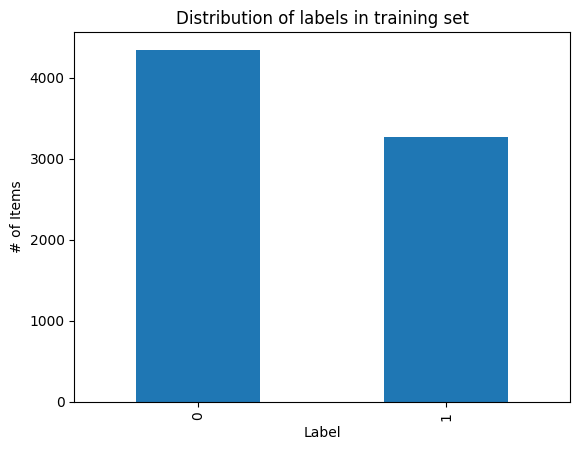

In [48]:
# Visualize the balance of labels...
label_counts = train_df['target'].value_counts()
label_counts.plot(kind="bar")
plt.title("Distribution of labels in training set")
plt.xlabel("Label")
plt.ylabel("# of Items")
plt.show()


## Visualizing the keyword feature
While there are a number of missing values, the keyword feature looks pretty robust with a number of unique values.  I'll keep this in the final training dataframe for now.

There are 221 unique keywords in the dataset
There are 61 missing keyword values


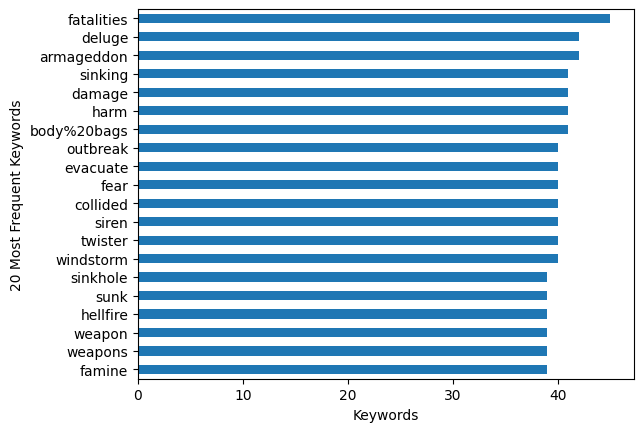

In [47]:
# Visualize the distribution of keywords
keyword_counts = train_df['keyword'].value_counts()
print(f"There are {len(keyword_counts)} unique keywords in the dataset")
print(f"There are {train_df['keyword'].isna().sum()} missing keyword values")
keyword_counts.nlargest(20).iloc[::-1].plot(kind="barh")
plt.xlabel("Keywords")
plt.ylabel("20 Most Frequent Keywords")
plt.show()

## Visualizing the location feature
Looking at the data, we might be better off omitting this data before training given the large amount of both unique values as well as missing values.

There are 3341 unique locations in the dataset
There are 2533 missing locations values


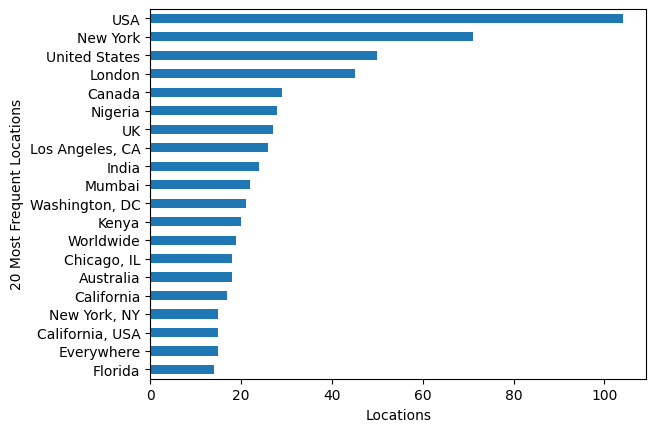

In [53]:
# Visualize the distribution of locations
location_counts = train_df['location'].value_counts(ascending=True)
print(f"There are {len(location_counts)} unique locations in the dataset")
print(f"There are {train_df['location'].isna().sum()} missing locations values")
location_counts.nlargest(20).iloc[::-1].plot(kind="barh")
plt.xlabel("Locations")
plt.ylabel("20 Most Frequent Locations")
plt.show()

## Analysis of the text itself
No missing or empty records, but there are a number of short posts (less than 20 characters).  Thankfully there are a majority of posts look to be at least 40 characters, and we have a normal-ish distribution over the number of words in the various posts.

Looking into the shorter posts, it looks like I can safely remove posts with one word or less than 10 characters without removing any positively labelled data

There are 0 missing/empty text values


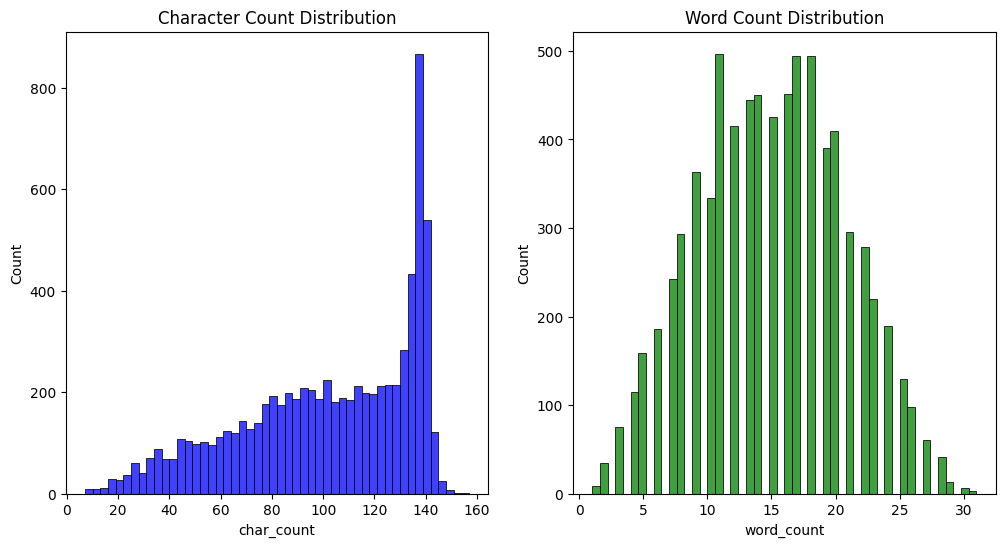

In [ ]:
print(f"There are {train_df['text'].isna().sum()} missing/empty text values")
train_df['char_count'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda str: len(str.split()))
char_count = train_df['char_count'].value_counts()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_df['char_count'], bins=50, color='blue')
plt.title('Character Count Distribution')


plt.subplot(1, 2, 2)
sns.histplot(train_df['word_count'], bins=50, color='green')
plt.title('Word Count Distribution')
plt.show()

In [72]:
train_df[train_df['char_count'] <= 10]
# train_df['char_count'].nsmallest(20)

,id,keyword,location,text,target,char_count,word_count
24,36,NaN,NaN,LOOOOOOL,0,8,1
28,40,NaN,NaN,Cooool :),0,9,2
30,44,NaN,NaN,The end!,0,8,2
1882,2703,crushed,NaN,Crushed,0,7,1
3667,5221,fatality,Nairobi,Fatality!,0,9,1
3670,5224,fatality,Rafael castillo,fatality,0,8,1
3749,5326,fire,NaN,I See Fire,0,10,3
4890,6962,massacre,NaN,Bad day,0,7,2
4971,7088,meltdown,NaN,Meltdown,0,8,1
5115,7295,nuclear%20reactor,NaN,Err:509,0,7,1


In [74]:
train_df[train_df['word_count'] < 2]


,id,keyword,location,text,target,char_count,word_count
24,36,NaN,NaN,LOOOOOOL,0,8,1
1882,2703,crushed,NaN,Crushed,0,7,1
3667,5221,fatality,Nairobi,Fatality!,0,9,1
3670,5224,fatality,Rafael castillo,fatality,0,8,1
4971,7088,meltdown,NaN,Meltdown,0,8,1
5115,7295,nuclear%20reactor,NaN,Err:509,0,7,1
5184,7400,obliterated,New York,Obliterated,0,11,1
6705,9605,thunder,NaN,Thunder???,0,10,1


In [ ]:
# Tokenize and count words
all_words = ' '.join(train_df['text']).split()
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word.lower() not in stop_words]
word_counts = Counter(filtered_words)

print(word_counts.most_common(20))

[('-', 763), ('like', 318), ('&amp;', 295), ('??', 214), ('via', 208), ('get', 183), ('fire', 148), ('...', 147), ('people', 146), ('2', 145), ('|', 142), ('one', 142), ('would', 116), ('new', 105), ('got', 103), ('New', 98), ('????', 96), ('know', 96), ('video', 93), ('going', 91)]


In [ ]:
# Top 10 bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))  # Change to (1, 1) for unigrams, (3, 3) for trigrams
ngrams = vectorizer.fit_transform(train_df['text'])
ngram_counts = zip(vectorizer.get_feature_names_out(), ngrams.sum(axis=0).tolist()[0])
sorted_ngrams = sorted(ngram_counts, key=lambda x: x[1], reverse=True)

print(sorted_ngrams[:10])

[('http co', 4306), ('https co', 410), ('in the', 308), ('of the', 256), ('û_ http', 217), ('on the', 129), ('to the', 126), ('to be', 108), ('for the', 97), ('at the', 85)]


In [ ]:
# Trigram analysis
vectorizer = CountVectorizer(ngram_range=(3,3))  # Change to (1, 1) for unigrams, (3, 3) for trigrams
ngrams = vectorizer.fit_transform(train_df['text'])
ngram_counts = zip(vectorizer.get_feature_names_out(), ngrams.sum(axis=0).tolist()[0])
sorted_ngrams = sorted(ngram_counts, key=lambda x: x[1], reverse=True)

print(sorted_ngrams[:10])

[('û_ http co', 217), ('liked youtube video', 42), ('video http co', 42), ('û_ https co', 35), ('homes razed by', 29), ('more homes razed', 29), ('northern california wildfire', 29), ('2015 http co', 28), ('bomber who detonated', 28), ('detonated bomb in', 28)]


In [84]:
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(train_df['text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
for index, topic in enumerate(lda.components_):
    print(f"Topic #{index}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic #0:
['2015', 'crash', 'killed', 'video', 'body', 'emergency', 'news', 'police', 'û_', 'http']
Topic #1:
['got', 'want', 'new', 'disaster', 'don', 'people', 'https', 'like', 'just', 'http']
Topic #2:
['emergency', 'amp', 'bomber', 'û_', 'california', 'https', 'old', 'suicide', 'news', 'http']
Topic #3:
['know', 'just', 'buildings', 'û_', 'amp', 'don', 'burning', 'https', 'like', 'http']
Topic #4:
['atomic', 'û_', 'hiroshima', 'japan', 'legionnaires', 'pm', 'https', 'families', 'amp', 'http']


In [ ]:
# Given there's such a high occurence of http within the posts, I wanted to take a peek if there were any patterns....
http_records = train_df[train_df['text'].str.contains("http")]
print(f"{len(http_records)} records which contain http")
train_df[train_df['text'].str.contains("http")]

3971 records which contain http


,id,keyword,location,text,target,char_count,word_count
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,5
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67,10
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,9
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,13
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,55,8
...,...,...,...,...,...,...,...
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,121,20
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1,134,16
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,11
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,8
